# TikTok Video Dataset Demo
This notebook demonstrates some example codes for the TikTok Dance Dataset

### Data Sources

Metadata (`meta_data.json`)
* Consists meta information of the videos (e.g., trend id, number of likes, music, ...)

Videos (`/videos_skeleton`)
* The actual mp4 files (annotated skeletons), named with the ID form the metadata

Poses (`/poses`)
* Pose time series extracted with the OpenPose model (Cao et al. 2017)

Angle Time Series (`angle_time_series_data.json`)
* The pose time series that has been converted to joint angles

Statistical Features (`statistical_features_data.json`)
* Using the pose time series some statistcal features were extracted (e.g., velocity, acceleration, asymmetry, ...)

### An overview on how we computed the features

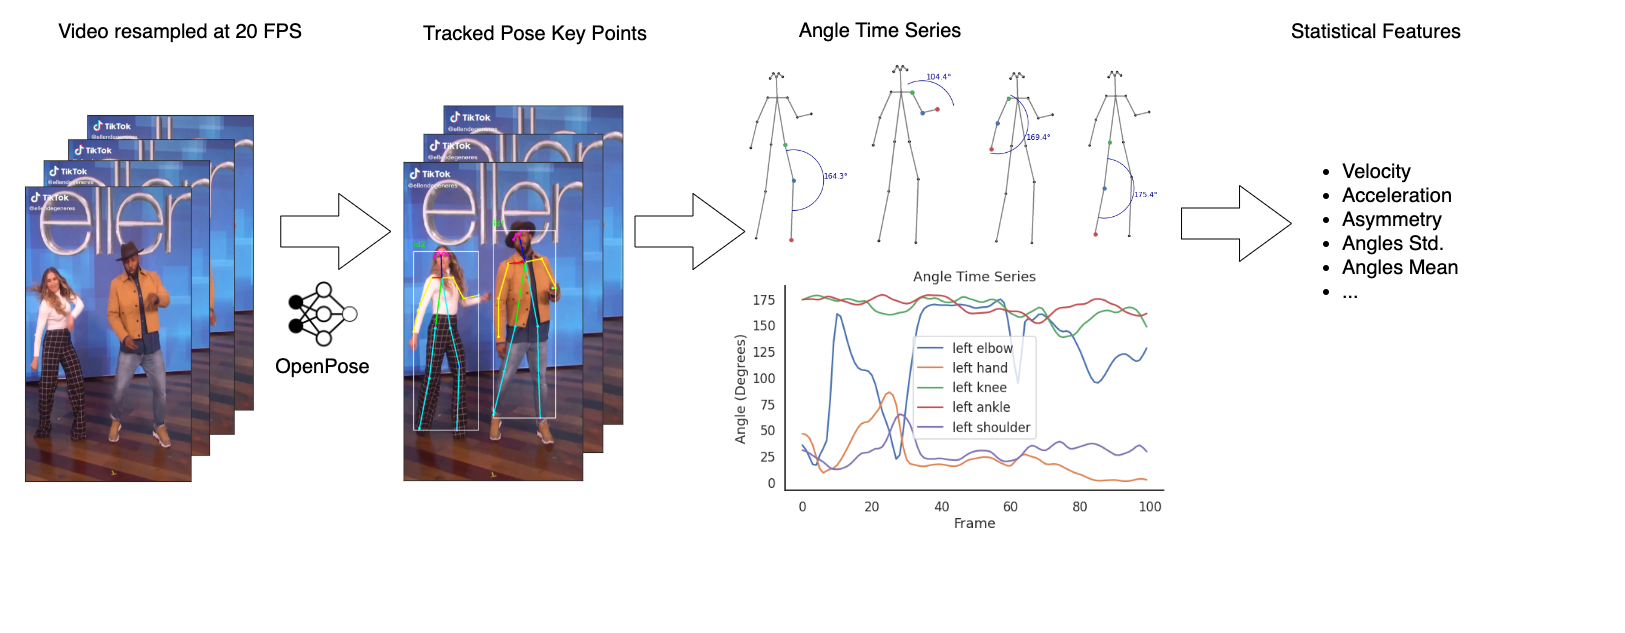

In [2]:
# Run this cell to install all required packages
!pip3 install -r requirements.txt

# Note: you might also need to manually install ffmpeg on your machine

You should consider upgrading via the '/Users/cocokoban/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [10]:
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import display, Video

import utilities as utils

%matplotlib inline

%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data_dir = Path("data")
assert data_dir.exists()

pose_dir = data_dir / "poses"
assert pose_dir.exists()

skeleton_videos_dir = data_dir / "videos_skeleton"
assert skeleton_videos_dir.exists()

fps = 20

### Load Metadata
This dataset contains all meta information for the videos (indicated by "id")

In [4]:
df_meta = pd.read_json(data_dir / "meta_data.json")
df_meta.head()

,id,date,num_days_online,video_duration,music_name,author_num_likes,author_num_followers,num_likes,num_shares,num_plays,num_comments,trend_median_num_plays,trend_median_num_likes,trend
25,6581033105748921606,2018-07-22 13:29:34,1362.272216,14,Monster,12500000,813800,287200,8283,5000000,10200,493350.0,45550.0,44.0
50,6585484066642988293,2018-08-03 13:21:34,1352.091932,15,None,21200,1647,30,6,496,3,476.5,21.5,612.0
86,6588532756412632325,2018-08-11 18:32:02,1007.659440,14,None,74300,9062,2590,30,48400,6,9794.0,608.0,393.0
121,6586429981285420293,2018-08-06 02:32:12,1391.688734,14,Mega Francesita (Remix),2900000,369400,2209,47,43100,35,40850.0,1538.5,889.0
197,6683944968031046917,2019-04-25 21:20:09,1088.120147,13,None,66700,5780,2358,171,48200,11,41900.0,2060.0,96.0


In [14]:
# for adding the labels
# df_meta.to_csv("meta_data.csv")

In [20]:
# import the labels

df_meta_labelled = pd.read_csv('labelled.csv')
df_meta_labelled.head()

,Unnamed: 0,date,num_days_online,video_duration,music_name,author_num_likes,author_num_followers,num_likes,num_shares,num_plays,...,skill_1,recognise_1,repetition_1,comment_1,creativity,complexity,memorability,creativity_1,complexity_1,memorability_1
0,25,2018-07-22 13:29:34,13.622.722.157.407,14,Monster,12500000,813800,287200,8283,5000000,...,2.0,4.0,1.0,NaN,7,4,5,7,4,5
1,50,2018-08-03 13:21:34,13.520.919.315.625,15,NaN,21200,1647,30,6,496,...,4.0,2.0,1.0,NaN,8,8,2,8,8,3
2,86,2018-08-11 18:32:02,10.076.594.403.935,14,NaN,74300,9062,2590,30,48400,...,3.0,2.0,1.0,NaN,7,6,3,6,6,3
3,121,2018-08-06 02:32:12,1.391.688.734.213,14,Mega Francesita (Remix),2900000,369400,2209,47,43100,...,1.0,4.0,1.0,NaN,6,2,5,5,2,5
4,197,2019-04-25 21:20:09,10.881.201.471.875,13,NaN,66700,5780,2358,171,48200,...,1.0,5.0,1.0,2 people,3,2,6,3,2,6


In [27]:
# calculating the inter-rater agreement - It gives a score of how much homogeneity, or consensus, there is in the ratings given by judges.
# Cohen's kappa: a statistic that measures inter-annotator agreement
# The kappa score (see docstring) is a number between -1 and 1. Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).
# Kappa scores can be computed for binary or multiclass problems, but not for multilabel problems (except by manually computing a per-label score) and not for more than two annotators.

from sklearn.metrics import cohen_kappa_score

df_meta_labelled.dropna(subset=['novel'], how='all', inplace=True)
df_meta_labelled.dropna(subset=['novel_1'], how='all', inplace=True)

print("novelty")
cohen_kappa_score(df_meta_labelled['novel'], df_meta_labelled['novel_1'], labels=None, weights='linear', sample_weight=None)
cohen_kappa_score(df_meta_labelled['novel'], df_meta_labelled['novel_1'], labels=[1,2,3,4,5], weights='linear')

cohen_kappa_score(df_meta_labelled['novel'], df_meta_labelled['novel_1'], labels=None, weights='quadratic', sample_weight=None)

print("entertainment")
cohen_kappa_score(df_meta_labelled['entertaining'], df_meta_labelled['entertaining_1'], labels=None, weights='linear', sample_weight=None)
cohen_kappa_score(df_meta_labelled['entertaining'], df_meta_labelled['entertaining_1'], labels=None, weights='quadratic', sample_weight=None)

print("learning")
cohen_kappa_score(df_meta_labelled['learn'], df_meta_labelled['learn_1'], labels=None, weights='linear', sample_weight=None)

print("skill")
cohen_kappa_score(df_meta_labelled['skill'], df_meta_labelled['skill_1'], labels=None, weights='linear', sample_weight=None)

print("recognise")
cohen_kappa_score(df_meta_labelled['recognise'], df_meta_labelled['recognise_1'], labels=None, weights='linear', sample_weight=None)

print("repition")
cohen_kappa_score(df_meta_labelled['repetition'], df_meta_labelled['repetition_1'], labels=None, weights='linear', sample_weight=None)


novelty


0.2281858074118226

0.11588658634301974

0.3453148688975298

entertainment


0.242854360800277

0.37739738492258845

learning


0.3098342469506159

skill


0.2943140848826934

recognise


0.2042785485335541

repition


0.05373347185855093

In [23]:
print("creativity")
cohen_kappa_score(df_meta_labelled['creativity'], df_meta_labelled['creativity_1'], labels=None, weights='linear', sample_weight=None)
cohen_kappa_score(df_meta_labelled['creativity'], df_meta_labelled['creativity_1'], labels=None, weights='quadratic', sample_weight=None)

print("complexity")
cohen_kappa_score(df_meta_labelled['complexity'], df_meta_labelled['complexity_1'], labels=None, weights='linear', sample_weight=None)
cohen_kappa_score(df_meta_labelled['complexity'], df_meta_labelled['complexity_1'], labels=None, weights='quadratic', sample_weight=None)

print("memorability")
cohen_kappa_score(df_meta_labelled['memorability'], df_meta_labelled['memorability_1'], labels=None, weights='linear', sample_weight=None)
cohen_kappa_score(df_meta_labelled['memorability'], df_meta_labelled['memorability_1'], labels=None, weights='quadratic', sample_weight=None)

creativity


0.23752526237720328

0.40191288832266525

complexity


0.3165395131976949

0.5174878853567835

memorability


0.1831299157429973

0.2801979295860453

![kappa interpretation](/kappa_interpretation.png)

** References:
https://www.wikiwand.com/en/Cohen%27s_kappa
https://towardsdatascience.com/inter-rater-agreement-kappas-69cd8b91ff75
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html

Randomly select video

In [5]:
video_id = df_meta.id.sample(1).iloc[0]
video_path = skeleton_videos_dir / f"{video_id}.mp4"

Show video

In [6]:
display(Video(video_path, width=200))

### Load Pose Data
* For each video, there exists a separate file containing all the tracked keypoints
* Each row of these dataframes indicate a separate frame of the video
* Look into the `utilities.py` script to see what each `part_idx` means (e.g., part_idx = 0 means the keypoints of the Nose)

In [7]:
df_pose = pd.read_json(pose_dir / f"{video_id}.json", lines=True)
df_pose.head(5)

,frame,human,part_idx,score,x,y,bounding_box,bounding_box_scaled,tracking_id
0,0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.808516, 0.781732, 0.6107819999999999, 0.727...","[0.476852, 0.5, 0.435185, 0.393519, 0.314815, ...","[0.429348, 0.494565, 0.48913000000000006, 0.53...","[0.314815, 0.41847799999999996, 0.671296, 0.82...","[170.0001, 401.73888, 362.49984, 793.04352]",1
1,1,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.81105, 0.717795, 0.593943, 0.72539000000000...","[0.476852, 0.49537000000000003, 0.435185, 0.39...","[0.429348, 0.494565, 0.48913000000000006, 0.53...","[0.314815, 0.41847799999999996, 0.671296, 0.83...","[170.0001, 401.73888, 362.49984, 798.26112]",1
2,2,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.769714, 0.658384, 0.7476100000000001, 0.804...","[0.472222, 0.490741, 0.42592599999999997, 0.38...","[0.429348, 0.494565, 0.48369599999999996, 0.53...","[0.314815, 0.41847799999999996, 0.675925999999...","[170.0001, 401.73888, 365.00004, 803.47872]",1
3,3,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.765118, 0.687789, 0.634764, 0.6972, 0.67514...","[0.472222, 0.49537000000000003, 0.430556, 0.38...","[0.429348, 0.494565, 0.48369599999999996, 0.53...","[0.310185, 0.41847799999999996, 0.680555999999...","[167.4999, 401.73888, 367.50024, 808.69536]",1
4,4,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.7534879999999999, 0.6982649999999999, 0.705...","[0.472222, 0.476852, 0.421296, 0.3842589999999...","[0.429348, 0.48369599999999996, 0.483695999999...","[0.305556, 0.41847799999999996, 0.680555999999...","[165.00024, 401.73888, 367.50024, 813.91296]",1


Load Video 

In [8]:
video = utils.load_video(skeleton_videos_dir / f"{video_id}.mp4", fps=fps)

In [9]:
@interact(frame=range(len(video)))
def show(frame):
    fig, ax = plt.subplots(figsize=(12,7))
    ax.axis("off")
    ax.imshow(video[frame])

interactive(children=(Dropdown(description='frame', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

### Load Angle Time Series Data
They tracked key points of each video were converted into a time series of angles (in Radians)

In [10]:
df_angles = pd.read_json(data_dir / "angle_time_series_data.json")
df_angles.head()

,left_elbow,left_hand,left_knee,left_ankle,left_shoulder,right_elbow,right_hand,right_knee,right_ankle,right_shoulder,id
0,"[2.1921787262, 2.2326059341, 2.1397969723, Non...","[0.6676350832, 0.7239592075, 0.616397499999999...","[0.7246302366, 0.6792079806, 1.1891674995, 1.1...","[2.7141621113000003, 2.6931135654, 2.535538673...","[0.4092471004, 0.4572256505, 0.3276188076, 0.2...","[2.4707694054, 2.4707694054, 2.72544837, 2.834...","[0.5032086968, 0.4877517521, 0.4245113432, 0.3...","[0.6376479864, 0.6492023468, 0.6823222041, 0.6...","[2.7673447132, 2.751881361, 2.873691082, 2.916...","[0.1996844411, 0.1842275113, 0.225704491100000...",6581033105748921606
1,"[3.0398097038, 3.0356323719, 3.0419037342, 3.0...","[0.305370003, 0.3380499482, 0.3327478468, 0.32...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[0.2539274991, 0.2873447239, 0.284240216, 0.29...","[3.0883483887, 3.092767477, 3.1010742188, 3.08...","[0.39717251060000003, 0.3924962282, 0.37363901...","[None, None, None, None, None, None, None, Non...","[None, None, None, None, None, None, None, Non...","[0.36939316990000004, 0.3674764633, 0.35255274...",6777884520914996224
2,"[2.6473915577, 2.8865032196, 2.9418025017, 3.0...","[0.7249091864, 0.7183991075, 0.6990511417, 0.6...","[3.0830566883, 3.0349268913, 2.9518370628, 2.9...","[2.9061233997, 2.9017767906, 2.8781073093, 2.9...","[0.5343711972, 0.6153978705, 0.6183102131, 0.6...","[2.44363904, 2.4191565514, 2.4465367794, 2.514...","[0.5731421113, 0.39839094880000003, 0.34684047...","[2.8709561825, 2.9910335541, 3.1068296432, 2.9...","[3.1324701309, 3.1108598709, 3.1066434383, 3.1...","[1.0007097721, 0.7581884265000001, 0.713393032...",6811261631549410565
3,"[2.8792228699, 2.459587574, 2.4147996902, None...","[0.1169892699, 0.2218999714, 0.2699544728, Non...","[2.6669766903000003, 2.6496913433, 2.580645799...","[2.9420220852, 2.830927372, 2.7318799496, 2.59...","[0.0066404124, 0.15963612500000002, 0.13994222...","[1.7649681568000002, 2.3484582901, None, None,...","[0.3630897701, 0.3077311814, None, None, None,...","[2.6321856975999998, 2.6599357128000003, 2.610...","[2.8519246578, 2.746152401, 2.6348574162, None...","[0.0530965962, 0.0585589632, None, None, None,...",6833100299037641990
4,"[2.6019396782, 2.3721430302, 2.4228377342, 2.4...","[0.34706753490000003, 0.36509159210000003, 0.3...","[3.0732553005, 3.0355136395, 3.022371769, 3.10...","[3.0227642059, 2.9478461742, 2.993559837300000...","[0.6265518665, 0.8038463593, 0.7028949857, 0.7...","[2.6974885464, 2.7903075218, 2.8841431141, 2.9...","[0.39610028270000003, 0.34706753490000003, 0.3...","[3.1097660065, 3.093719244, 3.0884094238, 3.06...","[2.9948709011, 3.0247588158, 3.0247588158, 3.0...","[0.6265518665, 0.5337327123, 0.5337327123, 0.4...",6850730267263438086


### Load Statistical Features
* Using the extracted poses, statistical features were computed

In [11]:
df_features = pd.read_json(data_dir / "statistical_features_data.json")
df_features.head()

,id,angle_std_left_knee,angle_std_left_hand,angle_std_left_ankle,angle_std_left_shoulder,angle_std_left_elbow,angle_std_right_knee,angle_std_right_hand,angle_std_right_ankle,angle_std_right_shoulder,...,body_shape_std,body_shape_mean,distance_to_camera_std,distance_to_camera_mean,pelvis_x_std,skeleton_centroid_mean_velocity,num_persons,std_persons,mean_persons,mean_tracking_duration
132,6581033105748921606,28.695227,42.988457,12.403142,29.710169,34.332268,27.609909,43.669464,9.291886,31.169205,...,0.026320,0.082478,0.023158,0.946565,0.047326,0.008018,1,0,1,13.968539
168,6585484066642988293,20.978842,39.748219,8.382774,28.286800,49.413979,20.189777,41.204659,8.097834,29.437258,...,0.045074,0.188790,0.024178,0.896669,0.045234,0.016177,1,0,1,14.905063
184,6586429981285420293,9.131381,71.775558,4.110940,38.325638,47.944675,13.099375,70.747643,4.908292,36.313560,...,0.049763,0.175011,0.011370,0.889807,0.024408,0.009196,1,0,1,13.968750
214,6588532756412632325,23.124943,51.350647,7.345956,31.510845,56.197716,18.374613,38.346111,7.397201,22.258430,...,0.036693,0.138357,0.015138,0.908103,0.095411,0.009548,1,0,1,13.468750
367,6600346203127287045,28.352245,42.503380,13.225422,30.823944,55.553722,23.928665,37.806789,11.035434,20.877399,...,0.074384,0.175104,0.024226,0.898963,0.066623,0.014421,1,0,1,13.495495


In [12]:
pd.set_option('display.max_columns', None)
df_features.head()

,id,angle_std_left_knee,angle_std_left_hand,angle_std_left_ankle,angle_std_left_shoulder,angle_std_left_elbow,angle_std_right_knee,angle_std_right_hand,angle_std_right_ankle,angle_std_right_shoulder,angle_std_right_elbow,angle_std,angle_mean_left_knee,angle_mean_left_hand,angle_mean_left_ankle,angle_mean_left_shoulder,angle_mean_left_elbow,angle_mean_right_knee,angle_mean_right_hand,angle_mean_right_ankle,angle_mean_right_shoulder,angle_mean_right_elbow,angle_mean,angle_max,velocity_std_left_knee,velocity_std_left_hand,velocity_std_left_ankle,velocity_std_left_shoulder,velocity_std_left_elbow,velocity_std_right_knee,velocity_std_right_hand,velocity_std_right_ankle,velocity_std_right_shoulder,velocity_std_right_elbow,velocity_std,velocity_mean_left_knee,velocity_mean_left_hand,velocity_mean_left_ankle,velocity_mean_left_shoulder,velocity_mean_left_elbow,velocity_mean_right_knee,velocity_mean_right_hand,velocity_mean_right_ankle,velocity_mean_right_shoulder,velocity_mean_right_elbow,velocity_mean,velocity_max,acceleration_std_left_knee,acceleration_std_left_hand,acceleration_std_left_ankle,acceleration_std_left_shoulder,acceleration_std_left_elbow,acceleration_std_right_knee,acceleration_std_right_hand,acceleration_std_right_ankle,acceleration_std_right_shoulder,acceleration_std_right_elbow,acceleration_std,acceleration_mean_left_knee,acceleration_mean_left_hand,acceleration_mean_left_ankle,acceleration_mean_left_shoulder,acceleration_mean_left_elbow,acceleration_mean_right_knee,acceleration_mean_right_hand,acceleration_mean_right_ankle,acceleration_mean_right_shoulder,acceleration_mean_right_elbow,acceleration_mean,acceleration_max,asymmetry_std_knee,asymmetry_std_hand,asymmetry_std_ankle,asymmetry_std_shoulder,asymmetry_std_elbow,asymmetry_mean_knee,asymmetry_mean_hand,asymmetry_mean_ankle,asymmetry_mean_shoulder,asymmetry_mean_elbow,asymmetry_velocity_std_knee,asymmetry_velocity_std_hand,asymmetry_velocity_std_ankle,asymmetry_velocity_std_shoulder,asymmetry_velocity_std_elbow,asymmetry_velocity_mean_knee,asymmetry_velocity_mean_hand,asymmetry_velocity_mean_ankle,asymmetry_velocity_mean_shoulder,asymmetry_velocity_mean_elbow,arms_crossing,hands_up,right_hand_up,left_hand_up,body_width_std,body_width_mean,body_height_std,body_height_mean,body_shape_std,body_shape_mean,distance_to_camera_std,distance_to_camera_mean,pelvis_x_std,skeleton_centroid_mean_velocity,num_persons,std_persons,mean_persons,mean_tracking_duration
132,6581033105748921606,28.695227,42.988457,12.403142,29.710169,34.332268,27.609909,43.669464,9.291886,31.169205,33.127220,29.299694,156.305679,37.497005,166.663239,40.953835,121.280266,152.697495,37.075779,167.368744,37.542900,128.028076,104.541298,174.841583,11.009312,12.948736,5.082776,8.271785,12.714696,11.938046,9.630567,4.916244,13.301476,9.856021,9.966966,7.337632,5.003616,3.305414,5.630219,8.801303,7.810289,4.796115,3.194673,6.463648,8.033091,6.037599,20.531992,9.163964,16.736666,4.365009,6.989323,11.790014,10.961329,7.386976,4.238570,15.012089,7.539190,9.418312,5.740275,5.078291,2.623198,4.420403,7.308780,6.013365,2.866640,2.618299,6.366892,6.321427,4.935757,18.301949,23.881224,25.981117,9.790063,18.107964,22.443327,21.169230,14.695203,10.749518,16.913748,26.980436,12.656833,15.521813,4.530238,13.018233,13.103061,7.827396,4.861130,2.944018,6.140246,8.976814,0.747153,0.706150,0.767654,0.838269,0.073423,0.230275,0.036455,0.360048,0.026320,0.082478,0.023158,0.946565,0.047326,0.008018,1,0,1,13.968539
168,6585484066642988293,20.978842,39.748219,8.382774,28.286800,49.413979,20.189777,41.204659,8.097834,29.437258,48.068287,29.380844,163.455597,31.351477,169.468018,36.050545,121.191704,160.343857,33.429321,167.149918,31.833031,135.580124,104.985367,176.242737,8.360719,27.241583,3.266609,19.469975,28.384470,8.167322,30.143015,3.820304,17.322197,30.521584,17.669775,4.673759,11.919140,2.666154,10.391273,15.576070,4.934457,12.363555,2.958467,10.755462,17.536392,9.377473,33.805847,7.989633,28.642002,2.685734,20.075846,

In [13]:
from pandas_profiling import ProfileReport

# Profile info (you have to install pandas_profiling -> pip install pandas_profiling)

#profile = df_meta.profile_report(minimal=True)
#profile.to_file(output_file="profile_meta.html")

#profile2 = df_features.profile_report(minimal=True)
#profile2.to_file(output_file="profile.html")

Summarize dataset:  65%|██████▌   | 13/20 [00:00<00:02,  2.92it/s, Describe variable:num_plays]             /Users/cocokoban/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/cocokoban/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
Render HTML:   0%|          | 0/1 [00:21<?, ?it/s]


KeyboardInterrupt: 

<ipython-input-25-6dac03d7db3d>:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


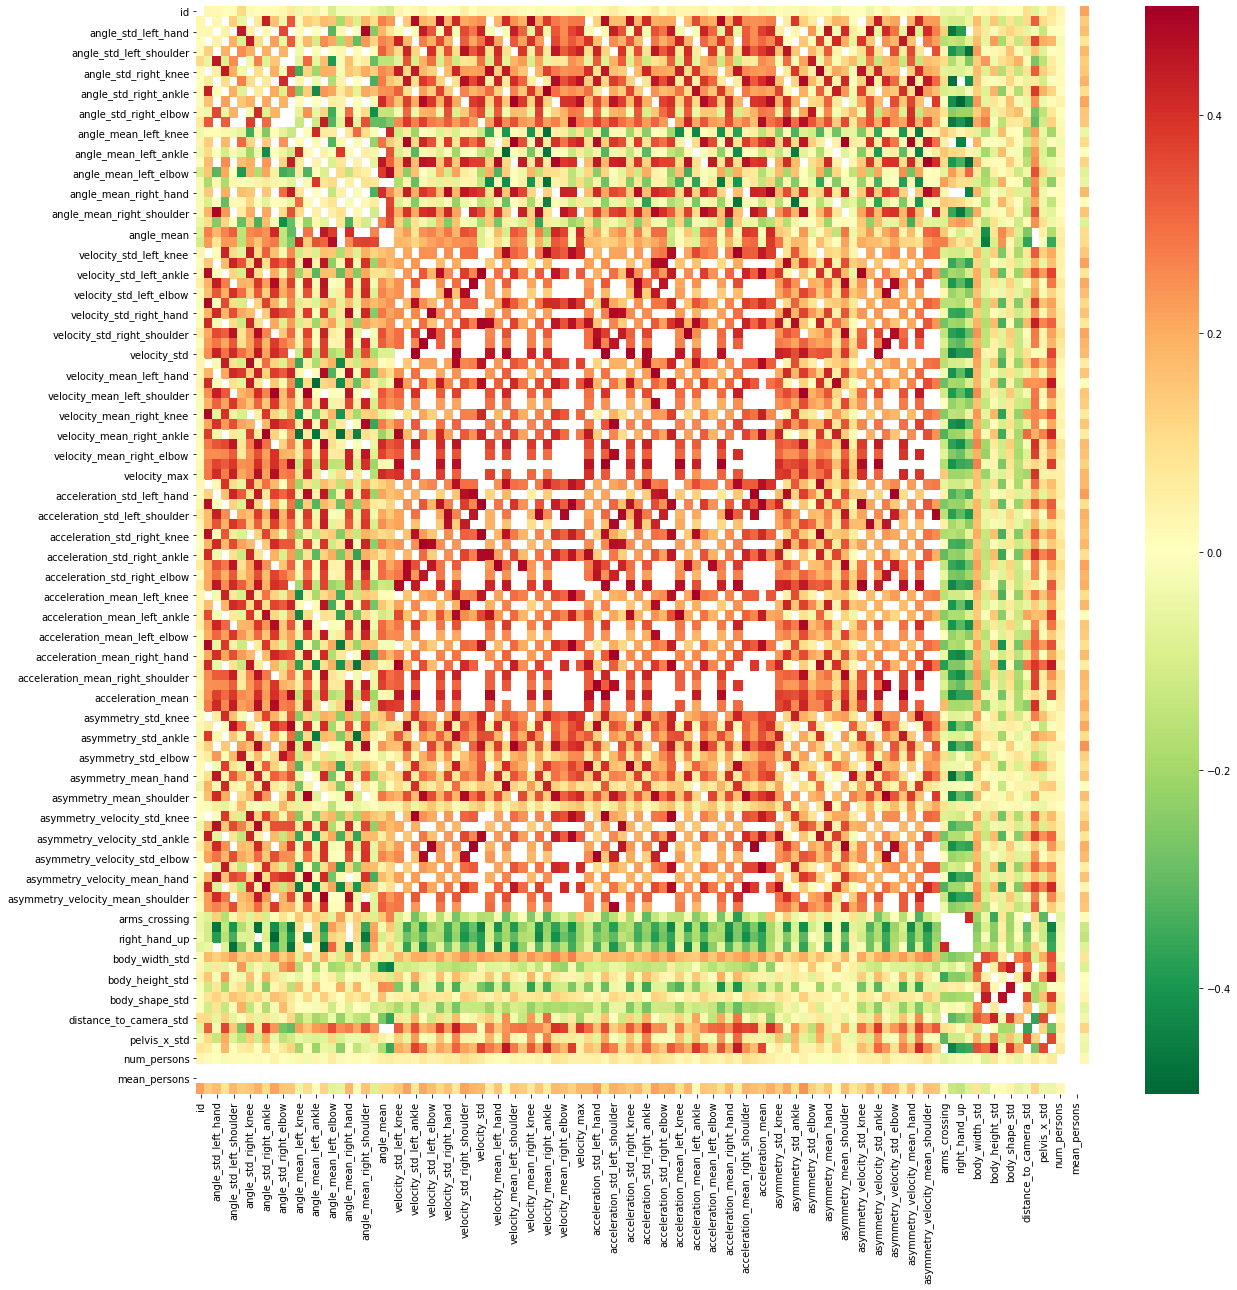

In [ ]:
import numpy as np # Data manipulation  
import matplotlib.pyplot as plt 
import seaborn 
c = df_features.corr() 
plt.figure(figsize=(20,20)) 
seaborn.heatmap(c, cmap='RdYlGn_r', mask = (np.abs(c) >= 0.5)) 
plt.show()